# <a id='start'></a> Analysis, comparison and validation of urbs results
This notebook was written by Leonhard Odersky and Magdalena Dorfner. This notebook is licensed under the [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)

In this notebook the results of scenarios modelled with urbs are analysed, compared and validated. For validation data from [Länderarbeitskreis Energiebilanzen](http://www.lak-energiebilanzen.de/) and [Bundesministerum für Wirtschaft und Energie](https://www.bmwi.de/Navigation/DE/Home/home.html) are taken. The notebook can be split in the following parts:

* [Input](#input) 
* [Validation of urbs](#validation)
* [Comparison of scenarios](#comparison)
    * [Comparison of produced electricity and CO2](#comp_elec&co2)
    * [Comparison of transmission](#comp_trans)
    * [Comparison of installed capacities](#comp_cap)
    * [Comparison of costs](#comp_cost)
    
    
* [Playground](#playground)

To run this notebook corretly, run the [Input](#input) part first!

***
***

## Input  <a id='input'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>
At first, needed packages are imported. Additionally, the input and global variables are defined.

In [1]:
import urbs
import pandas as pd
import os
import define
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

%matplotlib notebook

In [2]:
# Define input
folder_in = 'Input'
folder_out = 'Output'
subfolder = 'Visualization'
subfolder_lak = 'Timeseries'
dt_h5 = '.h5'
dt_csv = '.csv'
dt_png = '.png'

# Define input paths for LAK
lak_paths = {'conv': os.path.join(folder_in, subfolder_lak, 'Bruttostromerzeugung 2014 konventionell'+dt_csv),
             'renew': os.path.join(folder_in, subfolder_lak, 'Bruttostromerzeugung 2014 erneuerbar'+dt_csv),
             'CO2': os.path.join(folder_in, subfolder, 'lak-co2-2014'+dt_csv)}

# Define results to compare
scenarios = {'base': 'scenario_base',
             'nuclear_free': 'scenario_nuclear_free',
             #'coal_free': 'scenario_coal_free',
             #'coal_free_gas80': 'scenario_coal_free_gas80',
             'co2_2030': 'scenario_co2_2030'
            }

# Importing color codes
cmap = [define.tumgreen, define.tumivory, define.tumviolet,
        define.tumgrey, define.tumblue, define.tumbrown, define.tumred,
        define.tumblack, define.tumbrightyellow, define.tumorange, 
        define.tumturquois, define.tumlightblue]

tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite

# Importing dict to translate state names to English
translation = define.states_translation_de_en

# Importing dict to translate fuel names
translation_fuel = define.fuel_translation_de_en

# Import coordinates of the geographical center of each state
coordinates = define.coordinates_states_en


***
### Read in data from [Länderarbeitskreis Energiebilanzen](http://www.lak-energiebilanzen.de/)
Here, the comparison data from LAK is read in.

In [3]:
# Read in conventional production in Germany in 2014 
# Used columns for dem_load_states:
# 0: Bundesland - state
# 4-10: load for different production types per state
lak_conv = pd.read_csv(lak_paths['conv'], sep=';', na_values=['-', '.'], usecols=[0,4,5,6,7,8,10], 
                   index_col=0, skiprows=2, skipfooter=11, engine='python', encoding='latin1')
lak_conv.fillna(0, inplace=True)

# Read in renewable production in Germany in 2014 
# Used columns for dem_load_states:
# 0: Bundesland - state
# 4-8: load for different production types per state
lak_renew = pd.read_csv(lak_paths['renew'], sep=';', na_values=['-', '.'], usecols=[0,4,5,6,7,8], 
                    index_col=0, skiprows=2, skipfooter=7, engine='python', encoding='latin1')
lak_renew.fillna(0, inplace=True)

# Create dataframe for total production
lak_prod = pd.concat([lak_conv, lak_renew.iloc[:,1:]], axis=1)

# Translate states and fuel types to English
lak_prod = lak_prod.rename(index=translation)
lak_prod = lak_prod.rename(columns=translation_fuel)

# Add column 'Other plant' for easier comparison
lak_prod['Other plant'] = 0

# Sort dataframe
lak_prod = lak_prod.sort_index()
lak_prod = lak_prod.sort_index(axis=1)
lak_prod.head(5)

,Biomass plant,Gas plant,Geothermal plant,Hard coal plant,Lignite plant,Nuclear plant,Oil plant,Other plant,Solar plant,Waste plant,Wind plant
Baden-Württemberg,4466,3426,204.0,17990.0,0.0,21602.0,216.0,0,4648,2824.0,679
Bavaria,8105,7844,381.0,4177.0,0.0,42418.0,628.0,0,10382,1291.0,1803
Berlin,247,2427,0.0,4168.0,689.0,0.0,34.0,0,58,188.0,6
Brandenburg,3617,2943,166.0,0.0,33892.0,0.0,77.0,0,2657,3019.0,7962
Bremen,374,276,77.0,4290.0,0.0,0.0,22.0,0,29,1547.0,285


***
### Read in data from urbs
The results from urbs are read in. It is possible to read even more data, rather all data of the .h5 files. This might take a while.

In [4]:
# Define dicts for data

# Dict for all results
urbs_results = {}

# Dicts for Elec
urbs_elec = {}
urbs_elec_ts = {}
urbs_elec_ts_ger = {}

# Dicts for CO2
urbs_co2 = {}
urbs_co2_ts= {}
urbs_co2_ts_ger ={}

# Dicts for Transmission
urbs_tra = {}
urbs_tra_new = {}

# Dicts for Capacities
urbs_cap = {}
urbs_cap_new = {}

# Dict for costs
urbs_cost = {}

# Read in data for all scenarios
for scen in scenarios:
    # Read in results
    urbs_path = os.path.join(folder_in, subfolder, scenarios[scen]+dt_h5)
    helpdf = urbs.load(urbs_path)
    helpdf = helpdf._result
    
    # Filter results
    urbs_results[scen] = helpdf['e_pro_out'].unstack()
    
    # Get Elec data
    urbs_elec[scen] = urbs_results[scen]['Elec'].reorder_levels(['sit', 'pro', 't']).sort_index()
    urbs_elec_ts[scen] = urbs_elec[scen].unstack(level=0).unstack(level=0)
    urbs_elec_ts_ger[scen] = urbs_elec[scen].unstack(level=1).unstack(level=1).sum(axis=0).unstack().T.sum(axis=0)
    
    # Get CO2 data
    urbs_co2[scen] = urbs_results[scen]['CO2'].reorder_levels(['sit', 'pro', 't']).sort_index()
    urbs_co2_ts[scen] = urbs_co2[scen].unstack(level=0).unstack(level=0)
    urbs_co2_ts_ger[scen] = urbs_co2[scen].unstack(level=1).unstack(level=1).sum(axis=0).unstack().T.sum(axis=0)
    
    # Get Transmission data
    urbs_tra[scen] = helpdf['cap_tra'].unstack()
    urbs_tra_new[scen] = helpdf['cap_tra_new'].unstack()
    
    # Get process capacities
    urbs_cap[scen] = helpdf['cap_pro'].unstack()
    urbs_cap_new[scen] = helpdf['cap_pro_new'].unstack()
    
    # Get scenario costs
    urbs_cost[scen] = helpdf['costs']

***
***

## Validation of urbs<a id='validation'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

In this part the assumptions made in our model are validated. This is done by comparing the results of the 'base' scenario with data from [Länderarbeitskreis Energiebilanzen](http://www.lak-energiebilanzen.de/) and [Bundesministerum für Wirtschaft und Energie (BMWi)](https://www.bmwi.de/Navigation/DE/Home/home.html).

In [5]:
#Define data for co2, values taken from BMWi, unit is Mt
co2_bwe = {'Lignite plant': 158.7,
           'Hard coal plant': 97.4,
           'Gas plant': 41.4,
           'Oil plant': 4.8,
           'Waste plant': 14.3,
          }

co2_bwe = pd.DataFrame(list(co2_bwe.items()))
co2_bwe.set_index(0, inplace=True)

#Create dataframes for validation
urbs_elec_val = pd.DataFrame()
urbs_co2_val = pd.DataFrame()

help_elec_ger = urbs_elec_ts_ger['base']/1000000
help_co2_ger = urbs_co2_ts_ger['base']/1000000

# Try to store gas plants in one row and delete original rows
try:     
    help_elec_ger.loc['Gas plant'] = help_elec_ger.loc['CC plant'] + help_elec_ger.loc['Natural gas plant']
    help_co2_ger.loc['Gas plant'] = help_co2_ger.loc['CC plant'] + help_co2_ger.loc['Natural gas plant']
    help_elec_ger.drop(['CC plant', 'Natural gas plant'], inplace=True)
    help_co2_ger.drop(['CC plant', 'Natural gas plant'], inplace=True)    
except:
    pass

# Try to delete curtailment and slack rows, if zero
try: 
    if help_elec_ger.loc['Slack powerplant'].sum() == 0:
        help_elec_ger.drop(['Slack powerplant'], inplace=True)
        help_co2_ger.drop(['Slack powerplant'], inplace=True)
    if help_elec_ger.loc['Curtailment'].sum() == 0:
        help_elec_ger.drop(['Curtailment'], inplace=True)
        help_co2_ger.drop(['Curtailment'], inplace=True)
except:
    pass

# Add data for elec
urbs_elec_val = pd.concat([lak_prod.sum()/1000, help_elec_ger ], axis=1)
urbs_elec_val.rename(columns={0: 'LAE', 1: 'urbs'}, inplace=True)

#Add data for co2
urbs_co2_val = pd.concat([co2_bwe, help_co2_ger], axis=1)
urbs_co2_val.fillna(0, inplace=True)
urbs_co2_val.rename(columns={1: 'BMWi', 0: 'urbs'}, inplace=True)

# Adapt dataframes to comparison files
urbs_elec_val.sort_index(inplace=True)
urbs_co2_val.sort_index(inplace=True)


In [6]:
# Comparing produced electricity 
urbs_elec_val

,LAE,urbs
Biomass plant,47.055,66.610959
Gas plant,63.955,45.067639
Geothermal plant,2.322,0.292857
Hard coal plant,119.670,115.872737
Hydro plant,NaN,18.768142
Lignite plant,155.807,169.750541
Nuclear plant,97.129,98.976700
Oil plant,3.386,0.010750
Other plant,0.000,0.008359
Solar plant,33.976,33.259104


In [7]:
# Comparing produced CO2
urbs_co2_val

,BMWi,urbs
Biomass plant,0.0,0.000000
Gas plant,41.4,15.538314
Geothermal plant,0.0,0.000000
Hard coal plant,97.4,100.957836
Hydro plant,0.0,0.000000
Lignite plant,158.7,173.319655
Nuclear plant,0.0,0.000000
Oil plant,4.8,0.007256
Other plant,0.0,0.005787
Solar plant,0.0,0.000000


#### Plot validation of urbs with comparison data

<IPython.core.display.Javascript object>


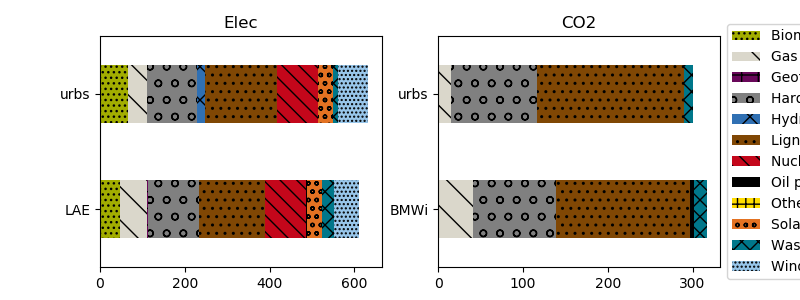

In [8]:
# Set hatch color
plt.rcParams['hatch.color'] = 'black'

# Plot validation in one figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), dpi=100)
fig.subplots_adjust(wspace = 0.2) # set space between subplots

# Plot elec
ax1 = urbs_elec_val.T.plot(kind='barh', stacked=True, legend=False, rot=0, color=cmap,
                           ax=axes[0]); axes[0].set_title('Elec');
# Add hatches
bars = ax1.patches
patterns =('...', '\\','+', 'o','x','..','\\\\','','++','oo','xx','....')
hatches = [p for p in patterns for i in range(len(urbs_elec_val.T))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# Add legend
#ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))#, prop={'size': })
ax1.set_xlabel('\n Electricity production per year [TWh]')

# Plot co2
ax2 = urbs_co2_val.T.plot(kind='barh', stacked=True, legend='reverse', rot=0, color=cmap,
                          ax=axes[1]); axes[1].set_title('CO2');
# Add hatches
plt.rcParams['hatch.color'] = 'black'
bars = ax2.patches
patterns =('...', '\\','+', 'o','x','..','\\\\','','++','oo','xx','....')
hatches = [p for p in patterns for i in range(len(urbs_co2_val.T))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# Add legend
ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))#, prop={'size': })
ax2.set_xlabel('\n CO2 production per year [Mt]')

# Define output and save file
val_file_out = 'Validation of urbs with LAK and BMWi'
val_path_out = os.path.join(folder_out, subfolder, val_file_out+dt_png)
plt.gcf().savefig(val_path_out, bbox_inches='tight', dpi=600)

***
***


## Comparison of scenarios<a id='comparison'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>

The results of the different modelled scenarios are compared in the following. To create the plots and tabels, this first cells has to be executed.

In [9]:
# Define dataframes for comparison
urbs_elec_comp = pd.DataFrame()
urbs_co2_comp = pd.DataFrame()
urbs_tra_comp = pd.DataFrame()
urbs_tra_new_comp = pd.DataFrame()
urbs_cap_comp = pd.DataFrame()
urbs_cap_new_comp = pd.DataFrame()
urbs_cost_comp = pd.DataFrame()
urbs_cost_diff = pd.DataFrame()

# Conacte data of scenarios in one dataframe
for scen in scenarios:
        urbs_elec_comp = pd.concat([urbs_elec_comp, urbs_elec_ts_ger[scen]], axis=1)
        urbs_co2_comp = pd.concat([urbs_co2_comp, urbs_co2_ts_ger[scen]], axis=1)
        urbs_tra_comp = pd.concat([urbs_tra_comp, urbs_tra[scen][urbs_tra[scen].Elec!=0]], axis=1)
        urbs_tra_new_comp = pd.concat([urbs_tra_new_comp, urbs_tra_new[scen][urbs_tra_new[scen].Elec!=0]], axis=1)
        urbs_cap_comp = pd.concat([urbs_cap_comp, urbs_cap[scen].sum()], axis=1)
        urbs_cap_new_comp = pd.concat([urbs_cap_new_comp, urbs_cap_new[scen].sum()], axis=1)
        urbs_cost_comp = pd.concat([urbs_cost_comp, urbs_cost[scen]], axis=1)
        urbs_cost_diff = pd.concat([urbs_cost_diff, urbs_cost[scen]-urbs_cost['base']], axis=1)
        
# Rename column names to scenarios names
urbs_elec_comp.columns = scenarios.keys()
urbs_co2_comp.columns = scenarios.keys()
urbs_tra_comp.columns = scenarios.keys()
urbs_tra_new_comp.columns = scenarios.keys()
urbs_cap_comp.columns = scenarios.keys()
urbs_cap_new_comp.columns = scenarios.keys()
urbs_cost_comp.columns = scenarios.keys()
urbs_cost_diff.columns = scenarios.keys()

# Try to store gas plants in one row and delete original rows
try:     
    urbs_elec_comp.loc['Gas plant'] = urbs_elec_comp.loc['CC plant'] + urbs_elec_comp.loc['Natural gas plant']
    urbs_co2_comp.loc['Gas plant'] = urbs_co2_comp.loc['CC plant'] + urbs_co2_comp.loc['Natural gas plant']
    urbs_elec_comp.drop(['CC plant', 'Natural gas plant'], inplace=True)
    urbs_co2_comp.drop(['CC plant', 'Natural gas plant'], inplace=True)    
except:
    pass

# Try to delete curtailment and slack rows, if zero
try: 
    if urbs_elec_comp.loc['Slack powerplant'].sum() == 0:
        urbs_elec_comp.drop(['Slack powerplant'], inplace=True)
        urbs_co2_comp.drop(['Slack powerplant'], inplace=True)
    if urbs_elec_comp.loc['Curtailment'].sum() == 0:
        urbs_elec_comp.drop(['Curtailment'], inplace=True)
        urbs_co2_comp.drop(['Curtailment'], inplace=True)
except:
    pass

# Adapt dataframes fro better reading
urbs_tra_new_comp.fillna(0, inplace=True)
urbs_elec_comp.sort_index(inplace=True)
urbs_co2_comp.sort_index(inplace=True)
# Elec in TWh
urbs_elec_comp = urbs_elec_comp/1000000
# CO2 in Mt
urbs_co2_comp = urbs_co2_comp/1000000

***
### Comparison of produced electricity and CO2 <a id='comp_elec&co2'></a>  
<div style="text-align: right"> Back to [beginning](#start).</div>
Necessary to run [first comparison cell](#comparison) first! 

The electirity and CO2 production of modeled scenarios are compared.

In [10]:
urbs_elec_comp

,base,nuclear_free,co2_2030
pro,,,
Biomass plant,66.610959,84.077794,83.864693
Gas plant,45.067639,184.278848,215.151407
Geothermal plant,0.292857,0.292857,0.292857
Hard coal plant,115.872737,116.376427,68.099745
Hydro plant,18.768142,18.768142,18.768142
Lignite plant,169.750541,123.940435,33.386587
Nuclear plant,98.976700,0.000000,0.000000
Oil plant,0.010750,0.286400,3.501471
Other plant,0.008359,0.113046,0.645258


In [11]:
urbs_co2_comp

,base,nuclear_free,co2_2030
pro,,,
Biomass plant,0.000000,0.000000,0.000000
Gas plant,15.538314,63.888384,80.102474
Geothermal plant,0.000000,0.000000,0.000000
Hard coal plant,100.957836,101.396692,59.334086
Hydro plant,0.000000,0.000000,0.000000
Lignite plant,173.319655,126.546362,34.088561
Nuclear plant,0.000000,0.000000,0.000000
Oil plant,0.007256,0.193320,2.363493
Other plant,0.005787,0.078262,0.446717


##### Plotting

<IPython.core.display.Javascript object>


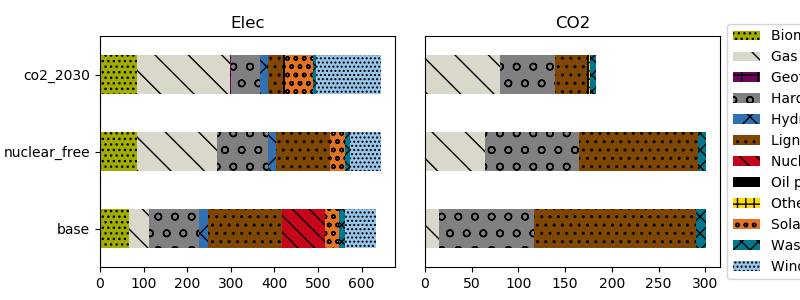

In [12]:
# Set hatch color
plt.rcParams['hatch.color'] = 'black'

# Plot comparison in one figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), dpi=100)

# Set space between subplots
fig.subplots_adjust(wspace = 0.1) 

# Plot elec
ax1 = urbs_elec_comp.T.plot(kind='barh', stacked=True, legend=False, rot=0, color=cmap,
                            ax=axes[0])
axes[0].set_title('Elec')
# Add hatches
bars = ax1.patches
patterns =('...', '\\','+', 'o','x','..','\\\\','','++','oo','xx','....')
hatches = [p for p in patterns for i in range(len(urbs_elec_comp.T))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
# Add legend
ax1.set_xlabel('\n Electricity production per year [TWh]')

# Plot co2
ax2 = urbs_co2_comp.T.plot(kind='barh', stacked=True, legend='reverse', rot=0, color=cmap,
                           ax=axes[1])
axes[1].set_title('CO2')
# Add hatches
plt.rcParams['hatch.color'] = 'black'
bars = ax2.patches
patterns =('...', '\\','+', 'o','x','..','\\\\','','++','oo','xx','....')
hatches = [p for p in patterns for i in range(len(urbs_co2_comp.T))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
# Add legend
ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))#, prop={'size': })
ax2.set_xlabel('\n CO2 production per year [Mt]')
ax2.set_yticks([]) 

# Define output and save file
comp_file_out = 'Comparison of urbs scenarios'
comp_path_out = os.path.join(folder_out, subfolder, comp_file_out+dt_png)
plt.gcf().savefig(comp_path_out, bbox_inches='tight', dpi=600)

---
### Comparison of transmission <a id='comp_trans'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>
Necessary to run [first comparison cell](#comparison) first!

The transmission expansion of the modeled scenarios are compared to the base scenario.

In [13]:
urbs_tra_new_comp

,,,base,nuclear_free,co2_2030
sit,sit_,tra,,,
Brandenburg,Mecklenburg-Vorpommern,hvac,0.0,0.0,2172.307895
Mecklenburg-Vorpommern,Brandenburg,hvac,0.0,0.0,2172.307895


##### Plotting

<IPython.core.display.Javascript object>


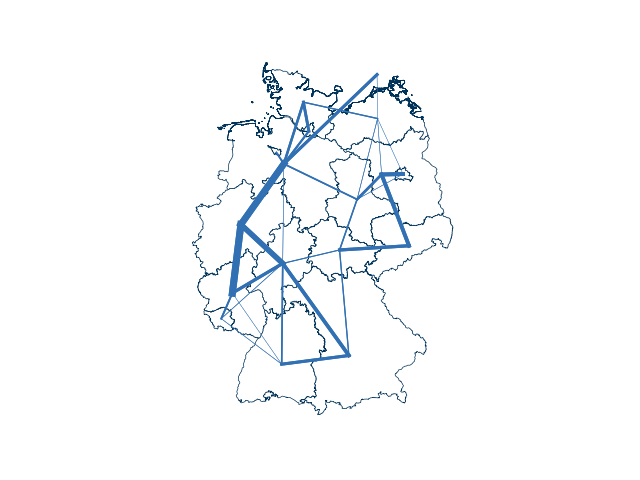

<IPython.core.display.Javascript object>


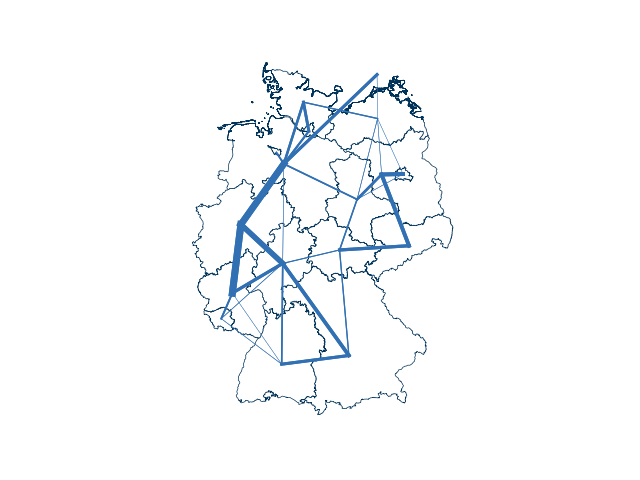

<IPython.core.display.Javascript object>


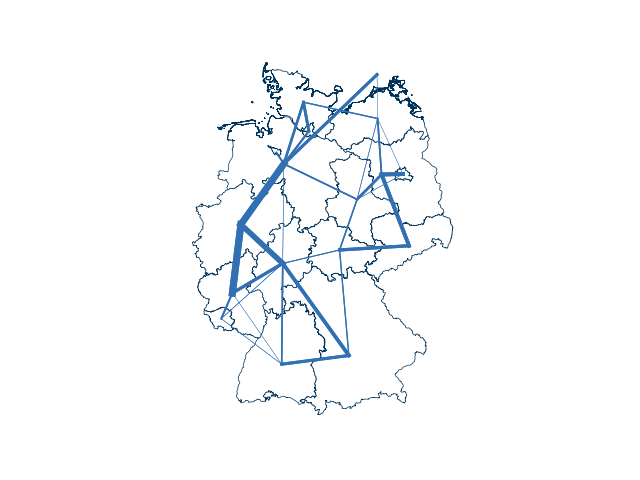

In [14]:
# Read in shape of germany
subfolder_tra = 'Shapes'
tra_file_shape = 'DEU_adm1.shp'
tra_path_shape = os.path.join(folder_in, subfolder, subfolder_tra, tra_file_shape)
tra_shape_ger = list(shpreader.Reader(tra_path_shape).geometries())

figures = {}

for scen in scenarios:

    # create figure per plot
    figures[scen] = plt.figure()

    # Generate shape
    ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
    ax.add_geometries(tra_shape_ger, ccrs.PlateCarree(), 
                      edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
    ax.set_extent([5.5, 15.5, 47, 55], ccrs.PlateCarree())
    #ax.set_title(scen)

    for key1 in urbs_tra[scen].index.get_level_values('sit').unique():
        for key2 in urbs_tra['base'].loc[key1].index.get_level_values('sit_'):
        # Weighting line with capacity
            plt.plot([coordinates[key1][1], coordinates[key2][1]], 
                         [coordinates[key1][0], coordinates[key2][0]],
                         color=tumblue, transform=ccrs.Geodetic(), 
                         linewidth=urbs_tra[scen].loc[key1].loc[key2].loc['hvac']['Elec']/2500)

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Define output and save plot to file
    tra_file_out = 'germany-lines-modeled-'+scen
    tra_path_out = os.path.join(folder_out, subfolder, tra_file_out+dt_png)
    plt.gcf().savefig(tra_path_out, bbox_inches='tight', dpi=600)

***
### Comparison of installed capacities<a id='comp_cap'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>
Necessary to run [first comparison cell](#comparison) first!

The capacitiy expansion of the modeled scenarios is compared to the base scenario.

In [15]:
urbs_cap_new_comp

,base,nuclear_free,co2_2030
pro,,,
Biomass plant,0.0,1599.836244,1599.836244
CC plant,0.0,5669.548900,5764.070738
Curtailment,0.0,0.000000,0.000000
Geothermal plant,0.0,0.000000,0.000000
Hard coal plant,0.0,0.000000,0.000000
Hydro plant,0.0,0.000000,0.000000
Lignite plant,0.0,0.000000,0.000000
Natural gas plant,0.0,0.000000,0.000000
Nuclear plant,0.0,0.000000,0.000000


***
### Comparison of costs<a id='comp_cost'></a> 
<div style="text-align: right"> Back to [beginning](#start).</div>
Necessary to run [first comparison cell](#comparison) first! 

The cost for the different sceanrios are looked at. Also the difference of the modeled scenarios compared to the base scenario is shown.

In [16]:
urbs_cost_comp

,base,nuclear_free,co2_2030
Environmental,0.000000e+00,0.000000e+00,0.000000e+00
Fixed,8.390476e+09,6.911528e+09,9.177388e+09
Fuel,9.960132e+09,1.472417e+10,1.480714e+10
Invest,0.000000e+00,7.077305e+08,1.036964e+10
Purchase,0.000000e+00,0.000000e+00,0.000000e+00
Revenue,0.000000e+00,0.000000e+00,0.000000e+00
Startup,0.000000e+00,0.000000e+00,0.000000e+00
Variable,-3.361734e+09,-5.995401e+09,-5.947882e+09


In [17]:
urbs_cost_diff

,base,nuclear_free,co2_2030
Environmental,0.0,0.000000e+00,0.000000e+00
Fixed,0.0,-1.478948e+09,7.869124e+08
Fuel,0.0,4.764041e+09,4.847010e+09
Invest,0.0,7.077305e+08,1.036964e+10
Purchase,0.0,0.000000e+00,0.000000e+00
Revenue,0.0,0.000000e+00,0.000000e+00
Startup,0.0,0.000000e+00,0.000000e+00
Variable,0.0,-2.633667e+09,-2.586148e+09


***
***